# **Working memory training**: Timeseries extraction

Timeseries extraction of data from working memory training experiment.

Filtering:
- 0.008 - 0.25 Hz

**Last edited:** 09-11-2018


Step 0: Loading libraries
-----------------------

In [2]:
%matplotlib inline

import sys
sys.path.append("..")

import os
import pandas as pd
import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from nilearn import datasets, plotting, input_data, signal, image  
from nilearn.input_data import NiftiLabelsMasker

from fctools import denoise

Step 1: Preparing paths to files
------------------------------

In [3]:
# Setting directories for input and output files
top_dir = '/media/finc/Elements/LearningBrain_fmriprep/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/01-extracted_timeseries/'

# Selecting subjects who finished the study
groups = pd.read_csv('../data/behavioral/group_assignment.csv')
subs = pd.Series.tolist(groups['sub'][groups['group'].isin(['Experimental', 'Control'])])

# Setting sessions and task names
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
tasks = {'rest': 305, 'dualnback': 340}
t_r = 2

suffix = '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
denoising = '_denoised_acompcor_task_effects.nii.gz'

print(f'Sample size: {len(subs)}')

Sample size: 46


Step 2: Creating parcellations 
--------------------------------

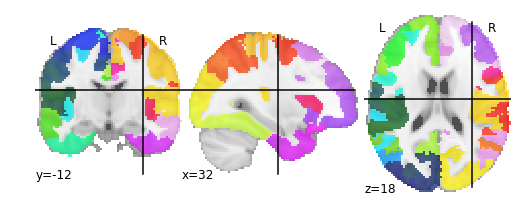

In [4]:
# Loading Power ROIs coordinates
power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file
power = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    radius = 5,
)

# Loading Schaefer atlas (300 regions)
atlas_filename = '/home/finc/Dropbox/Projects/LearningBrain/support/Schaefer2018_300Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'
plotting.plot_roi(atlas_filename)
schaefer = input_data.NiftiLabelsMasker(atlas_filename)


parcellations = np.asarray([[power, 'power', 264], 
                            [schaefer, 'schaefer', 300]])


Step 3: Extracting timeseries
----------------------

In [47]:
# Iterating over parcellations
for p in range(parcellations.shape[0]):
    n_roi = parcellations[p,2]
    
    # Iterating over tasks
    for task, n_scans in tasks.items():
        print(f'Extracting timeseries: {parcellations[p,1]} parcellation, {task}')
        timeseries_all = np.zeros((len(subs), len(sess), n_scans, n_roi))
        
        # Iterating over subjects, sessiosns
        for i, sub in enumerate(subs):
            print(f'Extracting timeseries {sub}')
            for j, ses in enumerate(sess):
                
                # Getting directory/file names
                sub_dir = f'{top_dir}{sub}/{ses}/func/'
                sub_name = f'{sub}_{ses}_task-{task}' 
                denoised_data = f'{sub_dir}{sub_name}{suffix[:-7]}{denoising}'

                if not os.path.exists(denoised_data):
                    print(f'{sub}{ses}{task} does not exist')
                else:
                    # Extracting timeseries for specified atlas
                    timeseries = parcellations[p,0].fit_transform(denoised_data, confounds=None)
                    # Filtering data
                    timeseries = signal.clean(timeseries, 
                                            low_pass=0.25, 
                                            high_pass=0.008, 
                                            t_r=t_r, 
                                            detrend=False, 
                                            standardize=True,
                                            )
                    timeseries_all[i, j, :, :] = timeseries
        np.save(f'{out_dir}/{task}/LB_{task}_timeseries_{parcellations[p,1]}_denoised_acompcor_no_smooth.npy', timeseries_all)

Extracting timeseries: schaefer_new parcellation, rest
Extracting timeseries sub-01
Extracting timeseries sub-02
Extracting timeseries sub-04
Extracting timeseries sub-05
Extracting timeseries sub-06
Extracting timeseries sub-07
Extracting timeseries sub-08
Extracting timeseries sub-10
Extracting timeseries sub-11
Extracting timeseries sub-12
Extracting timeseries sub-13
Extracting timeseries sub-14
Extracting timeseries sub-15
Extracting timeseries sub-16
Extracting timeseries sub-18
Extracting timeseries sub-19
Extracting timeseries sub-20
sub-20ses-2rest does not exist
Extracting timeseries sub-21
Extracting timeseries sub-23
Extracting timeseries sub-24
Extracting timeseries sub-25
Extracting timeseries sub-26
Extracting timeseries sub-27
Extracting timeseries sub-28
Extracting timeseries sub-29
Extracting timeseries sub-30
Extracting timeseries sub-33
Extracting timeseries sub-35
Extracting timeseries sub-36
Extracting timeseries sub-37
Extracting timeseries sub-39
Extracting time